In [ ]:
!nvidia-smi

Sat Jun 25 18:11:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/"

# Exploring Dataset

In [ ]:
for root, subdirs, files in os.walk('/content/drive/MyDrive/Colab Notebooks/DeepLearning/Project'):
    print(root, ", Number of files: ",len(files))

/content/drive/MyDrive/Colab Notebooks/DeepLearning/Project , Number of files:  1
/content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/transfer_vgg16_train , Number of files:  5
/content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/transfer_vgg16_train_512 , Number of files:  3
/content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset , Number of files:  0
/content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/JAWA TENGAH , Number of files:  0
/content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/JAWA TENGAH/Parang , Number of files:  500
/content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/JAWA TENGAH/Ceplok , Number of files:  502
/content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/JAWA TENGAH/Kawung , Number of files:  500
/content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/JAWA TENGAH/Sidomukti , Number of files:  500
/content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/P

# Creating Data Loader

In [ ]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
  parts = filename.split('/')
  label = parts[-2]
  
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [250, 250])
  return image, label

In [ ]:
# Plot the validation and training curves separately

def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss'])) # How many epochs

    
    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

Text(0.5, 1.0, 'Ceplok')

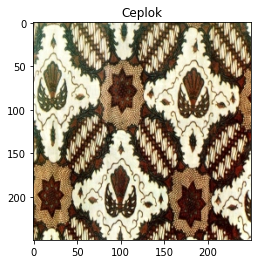

In [ ]:
image, label = parse_image(path+"dataset/JAWA TENGAH/Ceplok/1.jpg")
plt.imshow(image)
plt.title(label)

In [ ]:
def load_data(dir, manual_labelling=-1, class_names=None):
    dir_names = os.listdir(dir)
    
    X = []
    y = []
    for i in range(len(dir_names)):
        class_dir = dir + "/" + dir_names[i]
        filenames = os.listdir(class_dir)
        
        images = []
        print("reading", class_dir)
        for file in filenames:
            image, label = parse_image(class_dir + "/" + file)
            X.append(image)
            
            if manual_labelling != -1:
                y.append(manual_labelling)
            else:                
                if label == 'Sidomukti':
                    y.append(0)
                elif label == 'Parang':
                    y.append(1)
                elif label == 'Kawung':
                    y.append(2)
                elif label == 'Ceplok':
                    y.append(3)
                else:
                    print("NO LABEL")

    if manual_labelling != -1:
        return tf.stack(X), tf.stack(y), class_names
    else:
        return tf.stack(X), tf.one_hot(tf.stack(y), len(class_names)), class_names

# X, y, class_names = load_data("/content/drive/MyDrive/Colab Notebooks/DeepLearning/Proyek Akhir Deep Learning/JAWA TENGAH", class_names=['Sidomukti', 'Parang', 'Kawung', 'Ceplok'])   

In [ ]:
def load_data_multiclass_misc():    
    no_X, no_y, class_names = load_data(path+"dataset/JAWA TENGAH", class_names=['Sidomukti', 'Parang', 'Kawung', 'Ceplok', 'Lain-Lain'])   
    MD_X, MD_y, _ = load_data(path+'dataset/MADURA', 4)
    PK_X, PK_y, _ = load_data(path+'dataset/PEKALONGAN', 4)
    MD_y = np.repeat([[0, 0, 0, 0, 1]], len(MD_y), axis=0)
    PK_y = np.repeat([[0, 0, 0, 0, 1]], len(PK_y), axis=0)

    print(no_y.shape)
    print(MD_y.shape)

    X = np.concatenate((no_X, MD_X, PK_X), axis=0)
    y = np.concatenate((no_y, MD_y, PK_y), axis=0)
    
    return X, y, class_names

In [ ]:
def load_data_binary(dir):    
    class_names = ["NON JAWA TENGAH", "JAWA TENGAH"]
    JT_X, JT_y, _ = load_data(path+'dataset/JAWA TENGAH', 1)
    MD_X, MD_y, _ = load_data(path+'dataset/MADURA', 0)
    PK_X, PK_y, _ = load_data(path+'dataset/PEKALONGAN', 0)

    X = np.concatenate((JT_X, MD_X, PK_X), axis=0)
    y = np.concatenate((JT_y, MD_y, PK_y), axis=0)
    
    return X, y, class_names

X, y, class_names = load_data_binary(path+"dataset")

reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/JAWA TENGAH/Parang
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/JAWA TENGAH/Ceplok
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/JAWA TENGAH/Kawung
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/JAWA TENGAH/Sidomukti
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/MADURA/Pancawarna
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/MADURA/Serat Kayu
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/MADURA/Kacangan
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/PEKALONGAN/Terang Bulan
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/PEKALONGAN/Jlamprang
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/PEKALONGAN/Batik Liong
reading /content/drive/MyDrive/Colab Note

In [ ]:
X.shape, y.shape, class_names

((5247, 250, 250, 3), (5247,), ['NON JAWA TENGAH', 'JAWA TENGAH'])

In [ ]:
y

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

# Train Test Splitting


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X, y = None, None

len(X_train), len(X_test), len(y_train), len(y_test)

(4197, 1050, 4197, 1050)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

X_train, y_train, X_test, y_test = None, None, None, None

In [ ]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Binary VGG-16

In [ ]:
vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(250, 250, 3))
vgg16.trainable = True

## Create Callback

In [ ]:
checkpoint_path = path+"transfer_vgg16_train_4096_sigmoid/cp-{epoch:04d}.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         verbose=1)

## Binary Model

In [ ]:
# Setup model architecture
INPUT_SHAPE = (250, 250, 3)
inputs = tf.keras.Input(shape=INPUT_SHAPE, name="input_layer")

x = vgg16.output 

# x = tf.keras.layers.Flatten(name='flatten')(x)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

x = tf.keras.layers.Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dense(1000, activation='relu')(x)

outputs = tf.keras.layers.Dense(1,
                                activation='sigmoid',
                                name='output_layer')(x)

model = tf.keras.Model(vgg16.input, outputs)

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.input_shape, layer.output_shape, layer.trainable)

0 input_1 [(None, 250, 250, 3)] [(None, 250, 250, 3)] True
1 block1_conv1 (None, 250, 250, 3) (None, 250, 250, 64) True
2 block1_conv2 (None, 250, 250, 64) (None, 250, 250, 64) True
3 block1_pool (None, 250, 250, 64) (None, 125, 125, 64) True
4 block2_conv1 (None, 125, 125, 64) (None, 125, 125, 128) True
5 block2_conv2 (None, 125, 125, 128) (None, 125, 125, 128) True
6 block2_pool (None, 125, 125, 128) (None, 62, 62, 128) True
7 block3_conv1 (None, 62, 62, 128) (None, 62, 62, 256) True
8 block3_conv2 (None, 62, 62, 256) (None, 62, 62, 256) True
9 block3_conv3 (None, 62, 62, 256) (None, 62, 62, 256) True
10 block3_pool (None, 62, 62, 256) (None, 31, 31, 256) True
11 block4_conv1 (None, 31, 31, 256) (None, 31, 31, 512) True
12 block4_conv2 (None, 31, 31, 512) (None, 31, 31, 512) True
13 block4_conv3 (None, 31, 31, 512) (None, 31, 31, 512) True
14 block4_pool (None, 31, 31, 512) (None, 15, 15, 512) True
15 block5_conv1 (None, 15, 15, 512) (None, 15, 15, 512) True
16 block5_conv2 (None, 15

In [ ]:
for i, layer in enumerate(vgg16.layers):
    print(i, layer.name, layer.input_shape, layer.output_shape, layer.trainable)

0 input_1 [(None, 250, 250, 3)] [(None, 250, 250, 3)] True
1 block1_conv1 (None, 250, 250, 3) (None, 250, 250, 64) True
2 block1_conv2 (None, 250, 250, 64) (None, 250, 250, 64) True
3 block1_pool (None, 250, 250, 64) (None, 125, 125, 64) True
4 block2_conv1 (None, 125, 125, 64) (None, 125, 125, 128) True
5 block2_conv2 (None, 125, 125, 128) (None, 125, 125, 128) True
6 block2_pool (None, 125, 125, 128) (None, 62, 62, 128) True
7 block3_conv1 (None, 62, 62, 128) (None, 62, 62, 256) True
8 block3_conv2 (None, 62, 62, 256) (None, 62, 62, 256) True
9 block3_conv3 (None, 62, 62, 256) (None, 62, 62, 256) True
10 block3_pool (None, 62, 62, 256) (None, 31, 31, 256) True
11 block4_conv1 (None, 31, 31, 256) (None, 31, 31, 512) True
12 block4_conv2 (None, 31, 31, 512) (None, 31, 31, 512) True
13 block4_conv3 (None, 31, 31, 512) (None, 31, 31, 512) True
14 block4_pool (None, 31, 31, 512) (None, 15, 15, 512) True
15 block5_conv1 (None, 15, 15, 512) (None, 15, 15, 512) True
16 block5_conv2 (None, 15

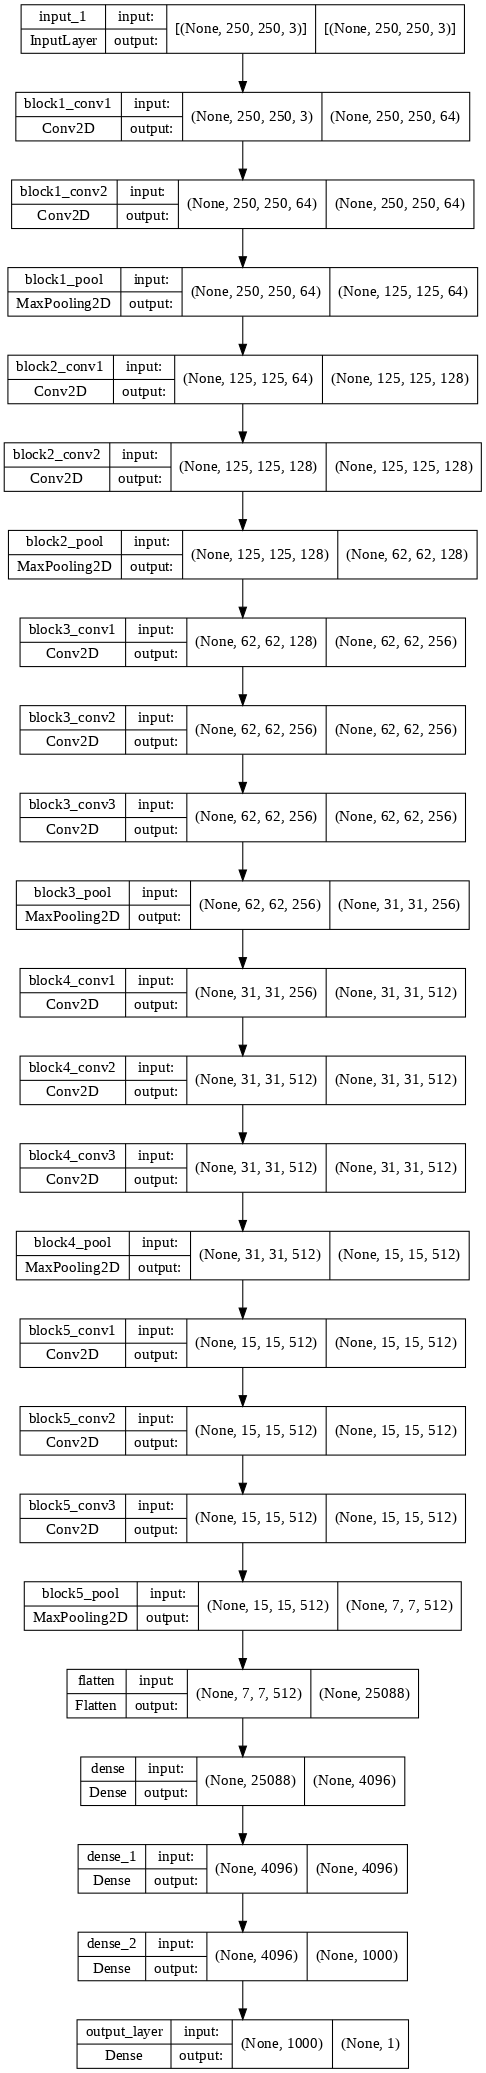

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
int(0.2 * len(test_dataset))

6

In [ ]:
history = model.fit(train_dataset,                    
                    validation_data=test_dataset,
                    validation_steps=int(0.2 * len(test_dataset)),
                    epochs=10,
                    callbacks=[checkpoint_callback])

Epoch 1/10
132/132 [==============================] - ETA: 0s - loss: 2.8538 - accuracy: 0.5945
Epoch 1: val_accuracy improved from -inf to 0.54688, saving model to /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/transfer_vgg16_train_4096_sigmoid/cp-0001.ckpt
132/132 [==============================] - 138s 886ms/step - loss: 2.8538 - accuracy: 0.5945 - val_loss: 0.7037 - val_accuracy: 0.5469
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.6221
Epoch 2: val_accuracy did not improve from 0.54688
132/132 [==============================] - 106s 802ms/step - loss: 0.6641 - accuracy: 0.6221 - val_loss: 0.7017 - val_accuracy: 0.5469
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.6221
Epoch 3: val_accuracy did not improve from 0.54688
132/132 [==============================] - 106s 800ms/step - loss: 0.6641 - accuracy: 0.6221 - val_loss: 0.7063 - val_accuracy: 0.5469
Epoch 4/10
132/132 [=========

In [ ]:
# fine_tune_epoch = 5 + 1 + history.epoch[-1]
# history_all_classes_10_percent_fine_tune = model.fit(train_dataset,
#                                                      epochs=fine_tune_epoch,                            
#                                                      validation_data=test_dataset,                                                     
#                                                      initial_epoch=history.epoch[-1], 
#                                                      callbacks=[checkpoint_callback])

In [ ]:
model.evaluate(test_dataset)

33/33 [==============================] - 12s 346ms/step - loss: 0.6731 - accuracy: 0.6038


[0.6731443405151367, 0.6038095355033875]

In [ ]:
# Setup model architecture
INPUT_SHAPE = (250, 250, 3)
inputs = tf.keras.Input(shape=INPUT_SHAPE, name="input_layer")

x = vgg16.output 

x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = tf.keras.layers.Dense(1,
                                activation='sigmoid',
                                name='output_layer')(x)

model = tf.keras.Model(vgg16.input, outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
latest = tf.train.latest_checkpoint(path+"transfer_vgg16")
latest

'/content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/transfer_vgg16/cp-0009.ckpt'

In [ ]:
loaded_model = tf.keras.models.clone_model(model)
loaded_model.load_weights(latest)

In [ ]:
loaded_model.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
loaded_model.evaluate(test_dataset)

33/33 [==============================] - 9s 211ms/step - loss: 0.4330 - accuracy: 0.8010


[0.4329647123813629, 0.8009523749351501]

In [ ]:
def show_pred_images(batch=0):
    iteration = 0
    for x, y in test_dataset:
        
        # print(x.shape, y.shape)
        if iteration != batch:
            iteration += 1
            continue
        
        preds_probs = loaded_model.predict(x)
        
        preds = tf.math.round(preds_probs).numpy()
        index_y = y.numpy()
        #index_y = tf.argmax(y, axis=1).numpy()
        # print(preds_probs)
        # print(preds)

        for i in range(x.shape[0]):
            conf_arr = preds_probs[i]
            #conf = conf_arr[int(preds[i])]
            if index_y[i] != preds[i]:
                plt.imshow(x[i])
                plt.title("Label: {y}; Predicted: {pred}\n ".format(y=class_names[index_y[i]], 
                                                                                    pred=class_names[int(preds[i])],
                                                                                    ))
                plt.axis(False)
                plt.show()
            
        

    
show_pred_images()

Output hidden; open in https://colab.research.google.com to view.

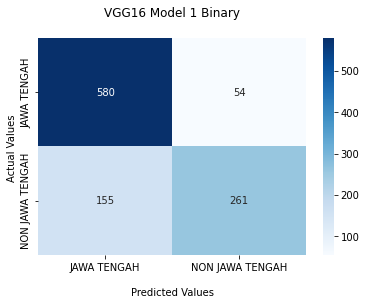

In [ ]:
y_pred = None
y_true = None

iteration = 0

for x, y in test_dataset:
    preds_probs = loaded_model.predict(x)
    
    preds = tf.math.round(preds_probs).numpy()
    index_y = y.numpy()
    
    if iteration == 0:
        y_pred = preds
    else:        
        y_pred = np.concatenate((y_pred, preds), axis=0)

    if iteration == 0:
        y_true = index_y
    else:
        y_true = np.concatenate((y_true, index_y), axis=0)

    iteration += 1
    

y_pred, y_true, y_pred.shape, y_true.shape
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
import seaborn as sns
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('VGG16 Model 1 Binary\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['JAWA TENGAH','NON JAWA TENGAH'])
ax.yaxis.set_ticklabels(['JAWA TENGAH','NON JAWA TENGAH'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Plot loss curves

In [ ]:
history.history

{'accuracy': [0.5944722294807434,
  0.6221110224723816,
  0.6221110224723816,
  0.6221110224723816,
  0.6221110224723816,
  0.6221110224723816,
  0.6221110224723816,
  0.6221110224723816,
  0.6221110224723816,
  0.6221110224723816],
 'loss': [2.8537511825561523,
  0.6640822887420654,
  0.6640506982803345,
  0.6644278764724731,
  0.664705216884613,
  0.6647039651870728,
  0.6640720963478088,
  0.6636614203453064,
  0.6638997197151184,
  0.6640884876251221],
 'val_accuracy': [0.546875,
  0.546875,
  0.546875,
  0.546875,
  0.546875,
  0.546875,
  0.546875,
  0.546875,
  0.546875,
  0.546875],
 'val_loss': [0.7036576271057129,
  0.7016749978065491,
  0.7062561511993408,
  0.7087607383728027,
  0.7122082710266113,
  0.7070910334587097,
  0.7053110599517822,
  0.7053316235542297,
  0.7054607272148132,
  0.7039673924446106]}

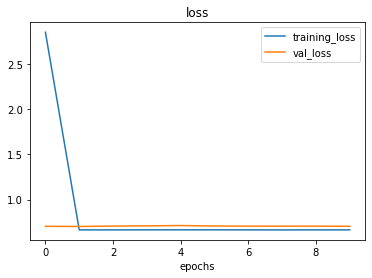

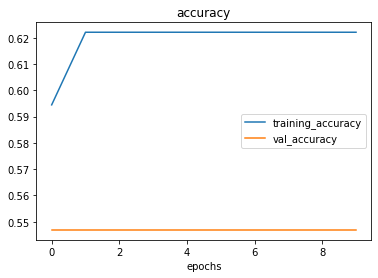

In [ ]:
plot_loss_curves(history)

# Test the Algorithm

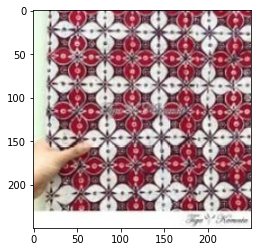

In [ ]:
image = tf.io.read_file(path+"dataset/JAWA TENGAH/Kawung/1.jpg")
image = tf.io.decode_jpeg(image)
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.image.resize(image, [250, 250])

plt.imshow(image)

In [ ]:
preds_prob = model.predict(tf.expand_dims(image, axis=0))
preds_prob[0][0]

0.4997286

In [ ]:
preds = round(preds_prob[0][0])
preds
if preds == 0:
    print("NON JAWA TENGAH")
else:
    print("JAWA TENGAH")

NON JAWA TENGAH


In [ ]:
image = tf.io.read_file(path+"dataset/JAWA TENGAH/Parang/1.jpg")
image = tf.io.decode_jpeg(image)
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.image.resize(image, [250, 250])

plt.imshow(image)

In [ ]:
preds_prob = model.predict(tf.expand_dims(image, axis=0))
preds_prob

In [ ]:
preds = round(preds_prob[0][0])
preds
if preds == 0:
    print("NON JAWA TENGAH")
else:
    print("JAWA TENGAH")

# Multiclass

In [ ]:
X, y, class_names = load_data_multiclass_misc()   

reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/JAWA TENGAH/Parang
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/JAWA TENGAH/Ceplok
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/JAWA TENGAH/Kawung
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/JAWA TENGAH/Sidomukti
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/MADURA/Pancawarna
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/MADURA/Serat Kayu
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/MADURA/Kacangan
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/PEKALONGAN/Terang Bulan
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/PEKALONGAN/Jlamprang
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/PEKALONGAN/Batik Liong
reading /content/drive/MyDrive/Colab Note

In [ ]:
X.shape, y.shape, class_names

((5247, 250, 250, 3),
 (5247, 5),
 ['Sidomukti', 'Parang', 'Kawung', 'Ceplok', 'Lain-Lain'])

In [ ]:
X

In [ ]:
y

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X, y = None, None

len(X_train), len(X_test), len(y_train), len(y_test)

(4197, 1050, 4197, 1050)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

X_train, y_train, X_test, y_test = None, None, None, None

In [ ]:
train_dataset

In [ ]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
checkpoint_path = path+"transfer_vgg16_multi_misc/cp-{epoch:04d}.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         verbose=1)

In [ ]:
vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(250, 250, 3))
vgg16.trainable = False

In [ ]:
# Setup model architecture
INPUT_SHAPE = (250, 250, 3)
inputs = tf.keras.Input(shape=INPUT_SHAPE, name="input_layer")

x = vgg16.output 

x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = tf.keras.layers.Dense(len(class_names),
                                activation='sigmoid',
                                name='output_layer')(x)

model = tf.keras.Model(vgg16.input, outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
history = model.fit(train_dataset,                    
                    validation_data=test_dataset,
                    validation_steps=int(0.2 * len(test_dataset)),
                    epochs=10,
                    callbacks=[checkpoint_callback])

Epoch 1/10
132/132 [==============================] - ETA: 0s - loss: 1.1028 - accuracy: 0.6097
Epoch 1: val_accuracy improved from -inf to 0.56771, saving model to /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/transfer_vgg16_multi_misc/cp-0001.ckpt
132/132 [==============================] - 118s 848ms/step - loss: 1.1028 - accuracy: 0.6097 - val_loss: 1.0479 - val_accuracy: 0.5677
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 0.8725 - accuracy: 0.6895
Epoch 2: val_accuracy improved from 0.56771 to 0.68229, saving model to /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/transfer_vgg16_multi_misc/cp-0002.ckpt
132/132 [==============================] - 109s 823ms/step - loss: 0.8725 - accuracy: 0.6895 - val_loss: 0.8978 - val_accuracy: 0.6823
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 0.7806 - accuracy: 0.7331
Epoch 3: val_accuracy improved from 0.68229 to 0.70833, saving model to /content/drive/MyDrive/Colab No

In [ ]:
model.evaluate(test_dataset)

33/33 [==============================] - 10s 263ms/step - loss: 0.6550 - accuracy: 0.7781


[0.6550195813179016, 0.7780952453613281]

In [ ]:
latest = tf.train.latest_checkpoint(path+"transfer_vgg16_multi_misc")
latest

'/content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/transfer_vgg16_multi_misc/cp-0008.ckpt'

In [ ]:
loaded_model = tf.keras.models.clone_model(model)
loaded_model.load_weights(latest)

In [ ]:
loaded_model.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
loaded_model.evaluate(test_dataset)

33/33 [==============================] - 10s 264ms/step - loss: 0.3681 - accuracy: 0.7686


[0.3680611252784729, 0.7685714364051819]

In [ ]:
def show_pred_images(batch=0):
    iteration = 0
    for x, y in test_dataset:
        
        # print(x.shape, y.shape)
        if iteration != batch:
            iteration += 1
            continue
        
        preds_probs = loaded_model.predict(x)
        
        preds = tf.argmax(preds_probs, axis=1).numpy()
        index_y = tf.argmax(y, axis=1).numpy()
        # print(preds_probs)
        # print(preds)

        for i in range(x.shape[0]):
            conf_arr = preds_probs[i]
            conf = conf_arr[preds[i]]

          
            plt.imshow(x[i])
            plt.title("Label: {y}; Predicted: {pred}\n Confidence: {conf:.000%}".format(y=class_names[index_y[i]], 
                                                                                pred=class_names[preds[i]],
                                                                                conf=conf))
            plt.axis(False)
            plt.show()
        
        

    
show_pred_images()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


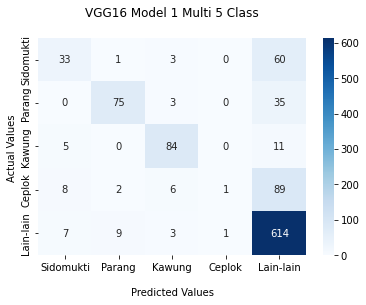

In [ ]:
y_pred = None
y_true = None

iteration = 0

for x, y in test_dataset:
    preds_probs = loaded_model.predict(x)
    
    preds = tf.argmax(preds_probs, axis=1).numpy()
    index_y = tf.argmax(y, axis=1).numpy()
    
    if iteration == 0:
        y_pred = preds
    else:        
        y_pred = np.concatenate((y_pred, preds), axis=0)

    if iteration == 0:
        y_true = index_y
    else:
        y_true = np.concatenate((y_true, index_y), axis=0)

    iteration += 1
    

y_pred, y_true, y_pred.shape, y_true.shape
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
import seaborn as sns
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('VGG16 Model 1 Multi 5 Class\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Sidomukti', 'Parang', 'Kawung', 'Ceplok', 'Lain-lain'])
ax.yaxis.set_ticklabels(['Sidomukti', 'Parang', 'Kawung', 'Ceplok', 'Lain-lain'])

## Display the visualization of the Confusion Matrix.
plt.show()


In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.input_shape, layer.output_shape, layer.trainable)

0 input_2 [(None, 250, 250, 3)] [(None, 250, 250, 3)] False
1 block1_conv1 (None, 250, 250, 3) (None, 250, 250, 64) False
2 block1_conv2 (None, 250, 250, 64) (None, 250, 250, 64) False
3 block1_pool (None, 250, 250, 64) (None, 125, 125, 64) False
4 block2_conv1 (None, 125, 125, 64) (None, 125, 125, 128) False
5 block2_conv2 (None, 125, 125, 128) (None, 125, 125, 128) False
6 block2_pool (None, 125, 125, 128) (None, 62, 62, 128) False
7 block3_conv1 (None, 62, 62, 128) (None, 62, 62, 256) False
8 block3_conv2 (None, 62, 62, 256) (None, 62, 62, 256) False
9 block3_conv3 (None, 62, 62, 256) (None, 62, 62, 256) False
10 block3_pool (None, 62, 62, 256) (None, 31, 31, 256) False
11 block4_conv1 (None, 31, 31, 256) (None, 31, 31, 512) False
12 block4_conv2 (None, 31, 31, 512) (None, 31, 31, 512) False
13 block4_conv3 (None, 31, 31, 512) (None, 31, 31, 512) False
14 block4_pool (None, 31, 31, 512) (None, 15, 15, 512) False
15 block5_conv1 (None, 15, 15, 512) (None, 15, 15, 512) False
16 block5

In [ ]:
plot_loss_curves(history)

# MultiClass Augmented PreTrained

In [ ]:
X, y, class_names = load_data(path+"augmented/JAWA TENGAH")   

In [ ]:
X.shape, y.shape, class_names

((4019, 250, 250, 3), (4019, 4), ['Ceplok', 'Sidomukti', 'Parang', 'Kawung'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X, y = None, None

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

X_train, y_train, X_test, y_test = None, None, None, None


In [ ]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
checkpoint_path = path+"transfer_vgg16_multi_augment/cp-{epoch:04d}.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         verbose=1)

In [ ]:
vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(250, 250, 3))
vgg16.trainable = False

# Setup model architecture
INPUT_SHAPE = (250, 250, 3)
inputs = tf.keras.Input(shape=INPUT_SHAPE, name="input_layer")

x = vgg16.output 

x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = tf.keras.layers.Dense(len(class_names),
                                activation='softmax',
                                name='output_layer')(x)

model = tf.keras.Model(vgg16.input, outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.input_shape, layer.output_shape, layer.trainable)

0 input_3 [(None, 250, 250, 3)] [(None, 250, 250, 3)] False
1 block1_conv1 (None, 250, 250, 3) (None, 250, 250, 64) False
2 block1_conv2 (None, 250, 250, 64) (None, 250, 250, 64) False
3 block1_pool (None, 250, 250, 64) (None, 125, 125, 64) False
4 block2_conv1 (None, 125, 125, 64) (None, 125, 125, 128) False
5 block2_conv2 (None, 125, 125, 128) (None, 125, 125, 128) False
6 block2_pool (None, 125, 125, 128) (None, 62, 62, 128) False
7 block3_conv1 (None, 62, 62, 128) (None, 62, 62, 256) False
8 block3_conv2 (None, 62, 62, 256) (None, 62, 62, 256) False
9 block3_conv3 (None, 62, 62, 256) (None, 62, 62, 256) False
10 block3_pool (None, 62, 62, 256) (None, 31, 31, 256) False
11 block4_conv1 (None, 31, 31, 256) (None, 31, 31, 512) False
12 block4_conv2 (None, 31, 31, 512) (None, 31, 31, 512) False
13 block4_conv3 (None, 31, 31, 512) (None, 31, 31, 512) False
14 block4_pool (None, 31, 31, 512) (None, 15, 15, 512) False
15 block5_conv1 (None, 15, 15, 512) (None, 15, 15, 512) False
16 block5

Epoch 1/10
101/101 [==============================] - ETA: 0s - loss: 1.1850 - accuracy: 0.5219
Epoch 1: val_accuracy improved from -inf to 0.65000, saving model to /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/transfer_vgg16_multi_augment/cp-0001.ckpt
101/101 [==============================] - 85s 837ms/step - loss: 1.1850 - accuracy: 0.5219 - val_loss: 1.0229 - val_accuracy: 0.6500
Epoch 2/10
101/101 [==============================] - ETA: 0s - loss: 0.9249 - accuracy: 0.6896
Epoch 2: val_accuracy improved from 0.65000 to 0.69375, saving model to /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/transfer_vgg16_multi_augment/cp-0002.ckpt
101/101 [==============================] - 84s 836ms/step - loss: 0.9249 - accuracy: 0.6896 - val_loss: 0.8859 - val_accuracy: 0.6938
Epoch 3/10
101/101 [==============================] - ETA: 0s - loss: 0.8110 - accuracy: 0.7356
Epoch 3: val_accuracy improved from 0.69375 to 0.71250, saving model to /content/drive/MyDrive/Cola

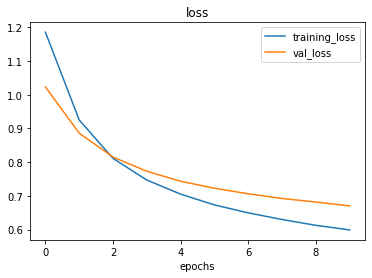

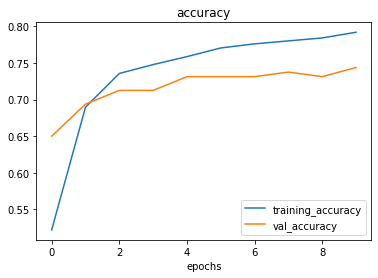

In [ ]:
tf.config.run_functions_eagerly(True)

history = model.fit(train_dataset,                    
                    validation_data=test_dataset,
                    validation_steps=int(0.2 * len(test_dataset)),
                    epochs=10,
                    callbacks=[checkpoint_callback])

plot_loss_curves(history)

In [ ]:
model.evaluate(test_dataset)

26/26 [==============================] - 8s 279ms/step - loss: 0.6098 - accuracy: 0.7799


[0.6097915172576904, 0.7798507213592529]

# MultiClass 


In [ ]:
X, y, class_names = load_data_multiclass_misc()   
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X, y = None, None

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

X_train, y_train, X_test, y_test = None, None, None, None


BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

checkpoint_path = path+"transfer_vgg16_multi_misc_train/cp-{epoch:04d}.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         verbose=1)



reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/JAWA TENGAH/Parang
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/JAWA TENGAH/Ceplok
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/JAWA TENGAH/Kawung
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/JAWA TENGAH/Sidomukti
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/MADURA/Pancawarna
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/MADURA/Serat Kayu
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/MADURA/Kacangan
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/PEKALONGAN/Terang Bulan
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/PEKALONGAN/Jlamprang
reading /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/dataset/PEKALONGAN/Batik Liong
reading /content/drive/MyDrive/Colab Note

In [ ]:
vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(250, 250, 3))
vgg16.trainable = True

# Setup model architecture
INPUT_SHAPE = (250, 250, 3)
inputs = tf.keras.Input(shape=INPUT_SHAPE, name="input_layer")

x = vgg16.output 

x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = tf.keras.layers.Dense(len(class_names),
                                activation='softmax',
                                name='output_layer')(x)

model = tf.keras.Model(vgg16.input, outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.input_shape, layer.output_shape, layer.trainable)

0 input_1 [(None, 250, 250, 3)] [(None, 250, 250, 3)] True
1 block1_conv1 (None, 250, 250, 3) (None, 250, 250, 64) True
2 block1_conv2 (None, 250, 250, 64) (None, 250, 250, 64) True
3 block1_pool (None, 250, 250, 64) (None, 125, 125, 64) True
4 block2_conv1 (None, 125, 125, 64) (None, 125, 125, 128) True
5 block2_conv2 (None, 125, 125, 128) (None, 125, 125, 128) True
6 block2_pool (None, 125, 125, 128) (None, 62, 62, 128) True
7 block3_conv1 (None, 62, 62, 128) (None, 62, 62, 256) True
8 block3_conv2 (None, 62, 62, 256) (None, 62, 62, 256) True
9 block3_conv3 (None, 62, 62, 256) (None, 62, 62, 256) True
10 block3_pool (None, 62, 62, 256) (None, 31, 31, 256) True
11 block4_conv1 (None, 31, 31, 256) (None, 31, 31, 512) True
12 block4_conv2 (None, 31, 31, 512) (None, 31, 31, 512) True
13 block4_conv3 (None, 31, 31, 512) (None, 31, 31, 512) True
14 block4_pool (None, 31, 31, 512) (None, 15, 15, 512) True
15 block5_conv1 (None, 15, 15, 512) (None, 15, 15, 512) True
16 block5_conv2 (None, 15

Epoch 1/10
132/132 [==============================] - ETA: 0s - loss: 1.3605 - accuracy: 0.6047
Epoch 1: val_accuracy improved from -inf to 0.54688, saving model to /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/transfer_vgg16_multi_misc_train/cp-0001.ckpt
132/132 [==============================] - 126s 802ms/step - loss: 1.3605 - accuracy: 0.6047 - val_loss: 1.3035 - val_accuracy: 0.5469
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 1.1485 - accuracy: 0.6276
Epoch 2: val_accuracy improved from 0.54688 to 0.57292, saving model to /content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/transfer_vgg16_multi_misc_train/cp-0002.ckpt
132/132 [==============================] - 103s 776ms/step - loss: 1.1485 - accuracy: 0.6276 - val_loss: 1.1364 - val_accuracy: 0.5729
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 1.0806 - accuracy: 0.6407
Epoch 3: val_accuracy improved from 0.57292 to 0.61979, saving model to /content/drive/MyDr

[0.8891691565513611, 0.7104762196540833]

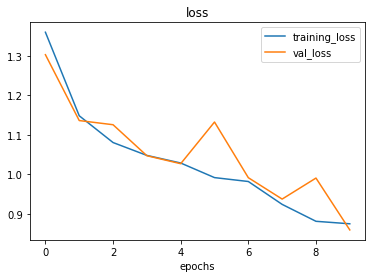

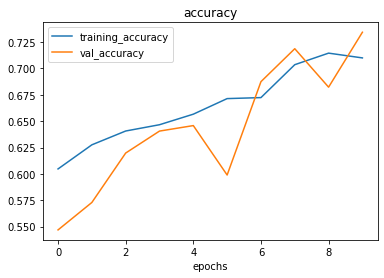

In [ ]:
tf.config.run_functions_eagerly(True)

history = model.fit(train_dataset,                    
                    validation_data=test_dataset,
                    validation_steps=int(0.2 * len(test_dataset)),
                    epochs=10,
                    callbacks=[checkpoint_callback])

plot_loss_curves(history)

model.evaluate(test_dataset)

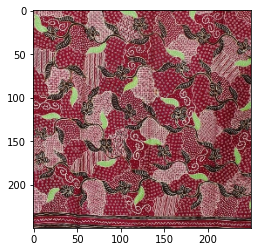

In [ ]:
image = tf.io.read_file(path+"dataset/MADURA/Kacangan/1.jpg")
image = tf.io.decode_jpeg(image)
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.image.resize(image, [250, 250])

plt.imshow(image)

In [ ]:
preds_prob = model.predict(tf.expand_dims(image, axis=0))
preds = tf.argmax(tf.squeeze(preds_prob))
preds
class_names[preds]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


'Lain-Lain'

In [ ]:
latest = tf.train.latest_checkpoint(path+"transfer_vgg16_multi_misc")
latest
loaded_model = tf.keras.models.clone_model(model)
loaded_model.load_weights(latest)
loaded_model.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])
loaded_model.evaluate(test_dataset)

33/33 [==============================] - 26s 293ms/step - loss: 0.4038 - accuracy: 0.7076


[0.4038189947605133, 0.7076190710067749]